In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from CNN_LSTM_MODEL import CNNLSTMDepthModel

#### TRIAL-LEVEL SESSION IDs

In [41]:
from pathlib import Path
import pandas as pd
import numpy as np

In [42]:
def segment_trials_sessionwise_with_ids(eeg, session_ids, fs, window_sec=10):
    samples_per_trial = fs * window_sec
    trials = []
    trial_session_ids = []

    for sid in np.unique(session_ids):
        idx = np.where(session_ids == sid)[0]
        session_eeg = eeg[:, idx]

        total = session_eeg.shape[1]
        for start in range(0, total - samples_per_trial, samples_per_trial):
            trials.append(session_eeg[:, start:start + samples_per_trial])
            trial_session_ids.append(sid)

    return np.stack(trials), np.array(trial_session_ids)

In [43]:
RAW_DATA_PATH = Path("./Data_raw/")

CSV_FILE = "combined.csv"   # your merged file
df = pd.read_csv(RAW_DATA_PATH / CSV_FILE)

EEG_CHANNELS = [
    "Fp1-A1", "Fp2-A2",
    "P3-A1", "P4-A2", "Pz-Aav",
    "O1-A1", "O2-A2",
    "Cz-Aav"
]

eeg = df[EEG_CHANNELS].values.T      # [C, T]
session_ids = df["session_id"].values

FS = 125

trials, trial_session_ids = segment_trials_sessionwise_with_ids(
    eeg, session_ids, fs=FS, window_sec=10
)

print(trial_session_ids.shape)  # (204,)

(204,)


#### RELOADING DATA

In [44]:
X = torch.load("X_eeg_tf.pt")        # [204, 8, 10, 21]
y = torch.load("y_pseudo.pt")        # [204]

print(X.shape, y.shape)

torch.Size([204, 8, 10, 21]) torch.Size([204])


### CONFIGURING DATA FOR TRAINING AND TESTING

In [50]:
test_session = 2

train_idx = trial_session_ids != test_session
test_idx  = trial_session_ids == test_session

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train samples:", X_train.shape[0])
print("Test samples:",  X_test.shape[0])

Train samples: 181
Test samples: 23


#### INITIALIZING THE MODEL

In [51]:
B, C, FREQ, TIME = X.shape

model = CNNLSTMDepthModel(num_channels=C)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### TRAINING ONLY ON TRAINING SESSIONS

In [52]:
train_ds = TensorDataset(X_train.to(device), y_train.to(device))
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}")

Epoch 10, Train Loss: 0.3971
Epoch 20, Train Loss: 0.0967
Epoch 30, Train Loss: 0.2344
Epoch 40, Train Loss: 0.0258
Epoch 50, Train Loss: 0.0097


#### EVALUATING ON THE UNSEEN SESSION

In [53]:
model.eval()
with torch.no_grad():
    logits_test = model(X_test.to(device))
    preds_test = torch.argmax(logits_test, dim=1)
    accuracy_test = (preds_test == y_test.to(device)).float().mean()

print("Test accuracy on session", test_session, ":", accuracy_test.item())

Test accuracy on session 2 : 1.0


#### CONFUSION MATRIX

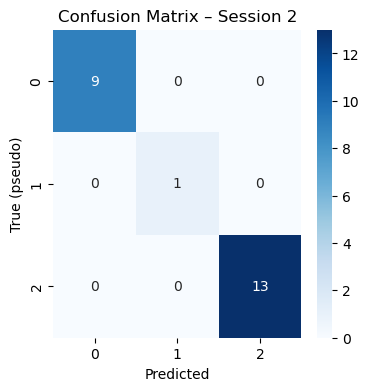

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.cpu(), preds_test.cpu())

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True (pseudo)")
plt.title(f"Confusion Matrix – Session {test_session}")
plt.show()